In [1]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


# Libraries

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon May 13 19:35:11 2019

@author: hippolyte
"""

import os
import h5py
import imgaug.augmenters as iaa
import numpy as np
import tensorflow as tf
import imgaug as aug
import datetime
import pickle

from keras.applications import vgg16, vgg19, xception
from keras.models import Model, Sequential, load_model, save_model
from keras.layers import Input, Conv2D, SeparableConv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.engine import InputLayer

from matplotlib import pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


# Variables

In [0]:
# root path of the project
ROOT_PATH = 'drive/My Drive/master1/medical_image_recognition/'
#ROOT_PATH = '/home/hippolyte/Documents/universite/m1/TER/'

# name of the dataset
DATASET_NAME = 'miniMIT_Etus'

# define image extensions we accept
IMAGE_EXTENSIONS = ['*.jpg', '*.jpeg']

# dimensions for the images
HEIGHT, WIDTH, CHANNELS = 224, 224, 3

# output var to see infos
VERBOSE = True

# paths to each directory
directory_list = None #['test', 'train', 'val']

# labels for each directory
# if setup to None, detect according to subdirectories inside each directory
label_list = None #['NORMAL', 'PNEUMONIA']

# image augmentation sequence
# WE DON'T USE THAT YET
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=30)]) # rotation

# the next instructions are used to make results reproducible
seed = 1234
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
tf.set_random_seed(seed)
aug.seed(seed)

################################################################################
# DON'T TOUCH THE VARIABLES UNDER
################################################################################

# these are helpers to ease consistency
DATASET_PATH = ROOT_PATH + 'datasets/' + DATASET_NAME + '/'
MODEL_PATH = ROOT_PATH + 'models/' + DATASET_NAME + '/'
ARRAY_PATH = ROOT_PATH + 'arrays/' + DATASET_NAME + '/'

# create the directories to save arrays and models if they don't exist
os.system('mkdir -p {} {}'.format(MODEL_PATH, ARRAY_PATH))

# list directories according to the list defined on top
if directory_list is None:
    DIRECTORIES = sorted([d for d in os.listdir(DATASET_PATH)])
else:
    DIRECTORIES = directory_list

# get the labels inside the first directory
# of course, it should be the same in every directory
if label_list is None:
    LABELS = sorted(os.listdir(DATASET_PATH + DIRECTORIES[0]))
else:
    LABELS = label_list

NUM_LABELS = len(LABELS)

# get the paths
PATHS = dict()
for cur_dir in DIRECTORIES:
    PATHS[cur_dir] = DATASET_PATH + cur_dir + '/'

# Data function

In [0]:
def get_data(directory: str):
    """
    TODO
    """
    shape_str = '({},{},{})'.format(HEIGHT, WIDTH, CHANNELS)
    
    with h5py.File(ARRAY_PATH + directory + shape_str + '.h5', 'r') as file:
        start = datetime.datetime.now()
        
        # assuming the file contains same amount of image and labels
        num_images = np.ceil(len(file.keys()) / 2).astype(int)
        print('Reading {} images from {} ...'.format(num_images, directory))

        # define arrays holding data and labels
        data = np.zeros((num_images, HEIGHT, WIDTH, CHANNELS), dtype=np.float32)
        labels = np.zeros((num_images, NUM_LABELS), dtype=np.float32)

        # iterate over all images
        # format is x0 y0 for the first image and so on
        for image_index in range(num_images):
            image = file['x' + str(image_index)]
            label = file['y' + str(image_index)]

            data[image_index] = image
            labels[image_index] = label

    # shapes
    print('Shapes. Data: {} Labels: {}'.format(data.shape,labels.shape))
    #data = np.array(data).astype(np.float32)
    #labels = np.array(labels)
    #print('Final shapes. {}   {}'.format(data.shape, labels.shape))
    
    end = datetime.datetime.now()
    print('Done in {} seconds.'.format((end-start).seconds))
    
    return data, labels

# Convolutional Neural Network functions

In [0]:
def create_vgg19(_model_name,
                 _frozen_layers=None,
                 _include_top=True):
    """
    TODO
    """
    
    # create the VGG model
    vgg19_model = vgg19.VGG19(include_top=_include_top,
                              weights='imagenet',
                              input_shape=(HEIGHT, WIDTH, CHANNELS))
   
    #vgg19_model.summary()
    
    # create a sequential model
    frozen_layers_str = '_'.join(_frozen_layers) if _frozen_layers else ''
    m_name = 'vgg19_' + frozen_layers_str
    model = Sequential(name=m_name)
    
    # add input layer
    model.add(InputLayer(input_shape=(HEIGHT, WIDTH, CHANNELS)))
    
    # convert vgg19 to sequential and remove the last layer
    for layer in vgg19_model.layers[:-1]:
        model.add(layer)
    
    #model.summary()
    
    # add last layer
    model.add(Dense(NUM_LABELS, activation='softmax', name='predictions'))
    
    #model.summary()
    
    # FREEZE PART
    if _frozen_layers is None:
        print('Everything is trainable')
        return model
    
    # freeze the first 5 blocks
    if 'blocks' in _frozen_layers:
        for i, layer in enumerate(model.layers):
            # freeze everything except fc1 and fc2
            if layer.name not in ['fc1', 'fc2']:
                #print('Not trainable', i, layer.name)
                layer.trainable = False
        
        print('Froze all blocks before classification one')
    
    # freeze fc1
    if 'fc1' in _frozen_layers:
        model.get_layer('fc1').trainable=False
        print('Froze fc1')

    # freeze fc2
    if 'fc2' in _frozen_layers:
        model.get_layer('fc2').trainable=False
        print('Froze fc2')
        
    return model

################################################################################
def create_vgg19custom(_model_name, _frozen_layers=[]):
    """
    TODO
    """
    
    # create the VGG model
    vgg19_model = vgg19.VGG19(include_top=False,
                              weights='imagenet',
                              input_shape=(HEIGHT, WIDTH, CHANNELS))
    
    """
    # freeze the layers according to `frozen_layers`
    for i, layer in enumerate(model.layers):
        if layer.name in _frozen_layers:
            print('Not trainable', i, layer.name)
            layer.trainable = False
        else:
            print('Trainable', i, layer.name)
            layer.trainable = True
    """
    
    model_name = 'vgg19_custom_'
    
    if 'blocks' in _frozen_layers:
        vgg19_model.trainable = False
        model_name += 'blocks'
    

    # create a sequential model and add the vgg19 model at bottom
    model = Sequential(name=model_name)
    model.add(vgg19_model)
    
    # add classification block
    model.add(Flatten(name='flatten'))
    model.add(Dense(1024, activation='relu', name='fc1')) #1024
    model.add(Dropout(0.7, name='dropout1'))              #notpresent
    model.add(Dense(512, activation='relu', name='fc2'))  #512
    model.add(Dropout(0.5, name='dropout2'))              #notpresent
    model.add(Dense(NUM_LABELS, activation='softmax', name='predictions'))
    
    #weights_list = model.get_weights()
    #for i, layer in enumerate(model.get_layer('vgg19').layers):
    #    print(i, layer.name)

    #vgg19_model.summary()
    #model.summary()
    
    return model

In [0]:
def compile_model(model, model_name, learning_rate=1e-5):
    """
    TODO
    """
    loss_type = 'binary' if NUM_LABELS == 2 else 'categorical'
    loss_type += '_crossentropy'
    optimizer = Adam(lr=learning_rate, decay=1e-5)
    
    model.compile(loss=loss_type,
                  metrics=['accuracy'],
                  optimizer=optimizer)

    return model

def train_model(model,
                model_name,
                train_data,
                train_labels,
                val_data,
                val_labels,
                epoch=20,
                batch_size=16,
                metric='val_loss',
                save_best_only=True,
                save_weights_only=True,
                stop_after=5,
                save_history=True):
    """
    TODO
    """
    early_stopping = EarlyStopping(patience=stop_after,
                                   monitor=metric,
                                   restore_best_weights=True)

    check_path = MODEL_PATH + 'model_{val_acc:2f}.hdf5'
    checkpoint = ModelCheckpoint(check_path,
                                 monitor=metric,
                                 verbose=1,
                                 save_best_only=save_best_only,
                                 save_weights_only=save_weights_only)

    # steps per epoch
    #train_steps = len(train_data) // batch_size
    #val_steps = len(val_data)

    print('Training {} model during {} epochs'.format(model.name, epoch))
    #print('{} train and {} val steps per epoch.'.format(train_steps, val_steps))

    # here we are, we'll train the model
    history = model.fit(x=train_data,
                        y=train_labels,
                        batch_size=batch_size,
                        epochs=epoch,
                        verbose=1,
                        callbacks=[early_stopping, checkpoint],
                        validation_split=0.0,
                        validation_data=(val_data, val_labels),
                        shuffle=True)
                        #class_weight={0: 1.0, 1: 0.4}) # TODO

    # save history
    if save_history is True:
        history_path = MODEL_PATH + 'history'
        print('\n\nSaving history into {} ...'.format(history_path))
        with open(history_path, 'wb') as history_file:
            pickle.dump(history.history, history_file)
    
    return model, history

def test_model(model, model_name, test_data, test_labels, batch_size=16):
    """
    TODO
    """
    test_loss, test_score = model.evaluate(test_data,
                                           test_labels,
                                           batch_size=16)

    print('Results for {} model.'.format(model_name))
    print('Loss : {}'.format(test_loss))
    print('Score : {}'.format(test_score))

    # predictions
    preds = model.predict(test_data, batch_size=16)
    preds = np.argmax(preds, axis=-1)

    # original labels
    orig_test_labels = np.argmax(test_labels, axis=-1)
    
    # confusion matrix
    cm  = confusion_matrix(orig_test_labels, preds)
    
    # metrics
    recall = np.diag(cm) / np.sum(cm, axis=1)
    precision = np.diag(cm) / np.sum(cm, axis=0)
    accuracy = np.diag(cm) / np.sum(cm)
    
    #tn, fp, fn, tp = cm.ravel()
    precision_ = 0 #tp / (tp + fp)
    recall_ =    0 #tp / (tp + fn)
    accuracy_ =  0 #(tp + tn) / (tn + fp + fn + tp)

    print("Recall of the model is {} - {:.5f}".format(recall, recall_))
    print("Precision of the model is {} - {:.5f}".format(precision, precision_))
    print("Accuracy of the model is {} - {:.5f}".format(accuracy, accuracy_))

    # plot confusion matrix
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
    plt.xticks(range(NUM_LABELS), LABELS, fontsize=16)
    plt.yticks(range(NUM_LABELS), LABELS, fontsize=16)
    plt.show()

# Let's do it !

## Data part

Reading 120 images from test ...
Shapes. Data: (120, 224, 224, 3) Labels: (120, 3)
Done in 0 seconds.


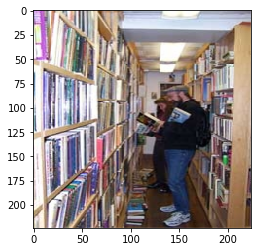

[1. 0. 0.]
Reading 120 images from train ...
Shapes. Data: (120, 224, 224, 3) Labels: (120, 3)
Done in 1 seconds.


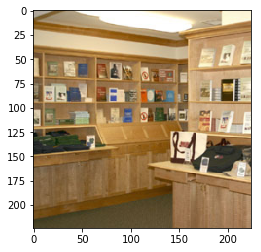

[1. 0. 0.]


In [7]:
data, labels = dict(), dict()

for directory in DIRECTORIES:
    # get data and labels
    data[directory], labels[directory] = get_data(directory)

    # plot an image with label
    if True:
        plt.imshow(data[directory][0])
        plt.show()
        print(labels[directory][0])

## CNN definition

In [0]:
# define the model we want to use
MODEL_NAME = 'vgg19'

# get the accurate model with weights
model = create_vgg19custom(MODEL_NAME, _frozen_layers=['blocks', 'fc1'])

# compile the model with optimizers and metrics
model = compile_model(model, MODEL_NAME)

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              25691136  
_________________________________________________________________
dropout1 (Dropout)           (None, 1024)              0         
_________________________________________________________________
fc2 (Dense)                  (None, 512)               524800    
_________________________________________________________________
dropout2 (Dropout)           (None, 512)               0         
_________________________________________________________________
predictions (Dense)          (None, 3)                 1539      
Total para

## CNN training
### USE IT WITH CAUTION, IT CAN TAKE TIME

In [14]:
# !!! WARNINGS !!!
# train or not is a question of time
model, history = train_model(model,
                             MODEL_NAME,
                             train_data=data['train'],
                             train_labels=labels['train'],
                             val_data=data['test'],
                             val_labels=labels['test'],
                             epoch=100,
                             batch_size=32,
                             metric='val_acc',
                             save_best_only=True,
                             save_weights_only=False,
                             stop_after=10)

Training vgg19_custom_blocks model during 100 epochs
Instructions for updating:
Use tf.cast instead.
Train on 120 samples, validate on 120 samples
Epoch 1/100
120/120 [==============================] - 11s 89ms/step - loss: 1.8072 - acc: 0.3417 - val_loss: 1.0769 - val_acc: 0.4000

Epoch 00001: val_acc improved from -inf to 0.40000, saving model to drive/My Drive/master1/medical_image_recognition/models/miniMIT_Etus/model_0.400000.hdf5
Epoch 2/100
120/120 [==============================] - 2s 13ms/step - loss: 1.6977 - acc: 0.3417 - val_loss: 1.0617 - val_acc: 0.4583

Epoch 00002: val_acc improved from 0.40000 to 0.45833, saving model to drive/My Drive/master1/medical_image_recognition/models/miniMIT_Etus/model_0.458333.hdf5
Epoch 3/100
120/120 [==============================] - 2s 13ms/step - loss: 1.4734 - acc: 0.4417 - val_loss: 1.0647 - val_acc: 0.4667

Epoch 00003: val_acc improved from 0.45833 to 0.46667, saving model to drive/My Drive/master1/medical_image_recognition/models/min

## Test : reload model

In [0]:
#del model#, history
#MODEL_NAME = 'vgg19'
#CNN_CONFIG_PATH = '7_vgg19(299,299,3)_blocks_fc1/'

#model = load_model(MODEL_PATH + 'test.hdf5') # CNN_CONFIG_PATH +
#model.summary()

## CNN results

624/624 [==============================] - 7s 11ms/step
Results for vgg19 model.
Loss : 0.46289859338176964
Score : 0.8862179487179487
Recall of the model is [0.72649573 0.98205128] - 0.00000
Precision of the model is [0.96045198 0.85682327] - 0.00000
Accuracy of the model is [0.2724359  0.61378205] - 0.00000


<Figure size 432x288 with 0 Axes>

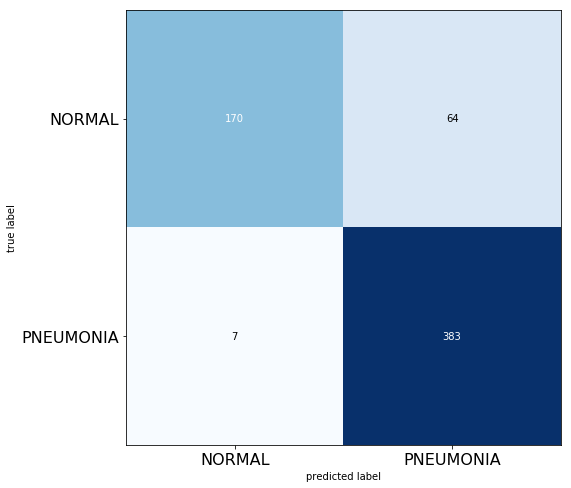

In [0]:
# normally, `restore_best_weights` in early_stoping callback should have work
# set to True if not
#if False:
#    # choose the weights to load into model
#    BEST_WEIGHTS = MODEL_PATH + 'vgg19_01_0.878205.hdf5'
#    model.load_weights(BEST_WEIGHTS)

# let's test our model !
test_model(model, MODEL_NAME, data['test'], labels['test'], batch_size=1)

In [0]:
# predictions
preds = model.predict(data['test'], batch_size=16)
preds = np.argmax(preds, axis=-1)

# original labels
orig_test_labels = np.argmax(labels['test'], axis=-1)

#print(preds, orig_test_labels)

## Plot history

Loading history from drive/My Drive/master1/medical_image_recognition/models/chest_xray/history ...


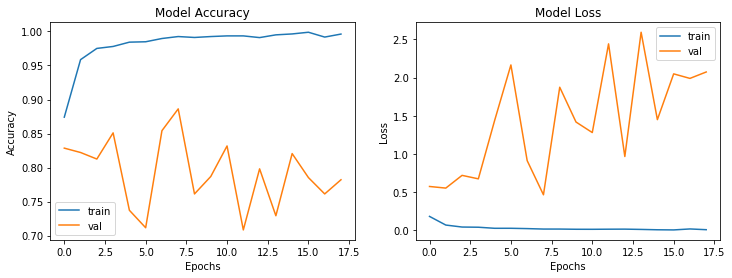

In [0]:
# load the history
history_path = MODEL_PATH + 'history' #CNN_CONFIG_PATH + 'history'
print('Loading history from {} ...'.format(history_path))
history = pickle.load(open(history_path, 'rb'))

fig, axes = plt.subplots(1, 2, figsize=(12, 4)) #, constrained_layout=True)

# accuracy
axes[0].plot(history['acc'])
axes[0].plot(history['val_acc'])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].legend(['train', 'val'])

# loss
axes[1].plot(history['loss'])
axes[1].plot(history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epochs')
axes[1].legend(['train', 'val'])
plt.show()

## Try to understand what our CNN learns

https://github.com/slundberg/shap

https://shap.readthedocs.io/en/latest/

https://www.kaggle.com/aakashnain/what-does-a-cnn-see

In [0]:
#! pip install shap

True labels are : [[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


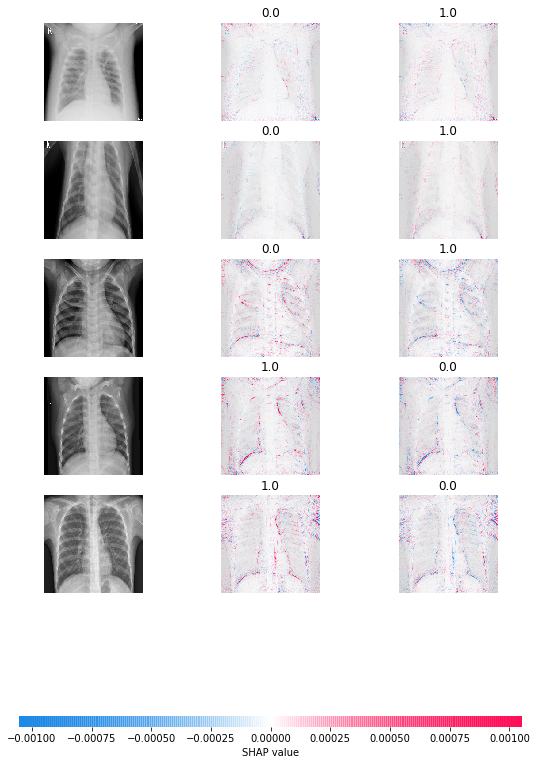

In [0]:
import shap

# syntaxic sugar
train_x = data['train']
test_x = data['test']
test_y = labels['test']

# random indexes
train_indexes = np.random.choice(train_x.shape[0], 10, replace=False)
test_indexes = np.random.choice(test_x.shape[0], 5, replace=False)

# let shap does its job
e = shap.DeepExplainer(model, train_x[train_indexes])
shap_values = e.shap_values(test_x[test_indexes])

# plot the results !
print('True labels are : {}'.format(test_y[test_indexes]))
shap.image_plot(shap_values, test_x[test_indexes], test_y[test_indexes])